BRAIN MRI TUMOR SEGMENTATION

In [3]:
!pip install kagglehub

import kagglehub

path = kagglehub.dataset_download("mateuszbuda/lgg-mri-segmentation")
print("Dataset path:", path)


Using Colab cache for faster access to the 'lgg-mri-segmentation' dataset.
Dataset path: /kaggle/input/lgg-mri-segmentation


In [19]:
import os
import glob

base_path = path + "/kaggle_3m"

image_paths = []
mask_paths = []

for patient in os.listdir(base_path):
    p_dir = os.path.join(base_path, patient)

    if os.path.isdir(p_dir):
        masks = glob.glob(p_dir + "/*_mask.tif")

        for m in masks:
            img = m.replace("_mask.tif", ".tif")
            if os.path.exists(img):
                image_paths.append(img)
                mask_paths.append(m)

print("Total images:", len(image_paths))
print("Total masks :", len(mask_paths))


Total images: 3929
Total masks : 3929


In [10]:
!pip install opencv-python segmentation-models-pytorch -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 6.1 MB/s eta 0:00:00


SEGMENTATION ANALYSIS

In [27]:
import cv2
import numpy as np
from skimage.filters import threshold_sauvola

def preprocess(gray):
    gray = cv2.GaussianBlur(gray, (5,5), 0)
    gray = cv2.equalizeHist(gray)
    return gray

def segment_otsu(gray):
    gray = preprocess(gray)
    _, th = cv2.threshold(gray, 0, 255,
                          cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    return th > 0

def segment_sauvola(gray):
    gray = preprocess(gray)
    t = threshold_sauvola(gray, window_size=31)
    return gray > t

METRICS EVALUATION

In [28]:
def dice_score(pred, true):
    inter = np.logical_and(pred, true).sum()
    return 2*inter / (pred.sum() + true.sum() + 1e-8)

def jaccard_score(pred, true):
    inter = np.logical_and(pred, true).sum()
    union = np.logical_or(pred, true).sum()
    return inter / (union + 1e-8)

In [37]:
dice_o, dice_s = [], []
jac_o, jac_s = [], []

for ip, mp in zip(image_paths, mask_paths):

    img  = cv2.imread(ip, cv2.IMREAD_GRAYSCALE)
    mask = cv2.imread(mp, cv2.IMREAD_GRAYSCALE)
    mask = (mask > 10).astype(np.uint8)

    otsu = segment_otsu(img)
    sauv = segment_sauvola(img)

    dice_o.append(dice_score(otsu, mask))
    dice_s.append(dice_score(sauv, mask))

    jac_o.append(jaccard_score(otsu, mask))
    jac_s.append(jaccard_score(sauv, mask))

print("Evaluation completed")

Evaluation completed


In [34]:
import numpy as np

results = {
    "Dice Otsu Mean": np.mean(dice_o),
    "Dice Otsu Std":  np.std(dice_o),

    "Dice Sauvola Mean": np.mean(dice_s),
    "Dice Sauvola Std":  np.std(dice_s),

    "Jaccard Otsu Mean": np.mean(jac_o),
    "Jaccard Otsu Std":  np.std(jac_o),

    "Jaccard Sauvola Mean": np.mean(jac_s),
    "Jaccard Sauvola Std":  np.std(jac_s),
}

for k,v in results.items():
    print(k, ":", round(v,4))

Dice Otsu Mean : 0.0377
Dice Otsu Std : 0.0719
Dice Sauvola Mean : 0.0262
Dice Sauvola Std : 0.0493
Jaccard Otsu Mean : 0.0207
Jaccard Otsu Std : 0.0409
Jaccard Sauvola Mean : 0.014
Jaccard Sauvola Std : 0.0269


COMPARISON TABLE

In [35]:
import pandas as pd

table = pd.DataFrame({
    "Method": ["Otsu", "Sauvola"],
    "Dice Mean": [np.mean(dice_o), np.mean(dice_s)],
    "Dice Std":  [np.std(dice_o), np.std(dice_s)],
    "Jaccard Mean": [np.mean(jac_o), np.mean(jac_s)],
    "Jaccard Std":  [np.std(jac_o), np.std(jac_s)],
})

table

,Method,Dice Mean,Dice Std,Jaccard Mean,Jaccard Std
0,Otsu,0.037749,0.071876,0.020734,0.040917
1,Sauvola,0.026249,0.049310,0.013971,0.026921


VISUALIZATION

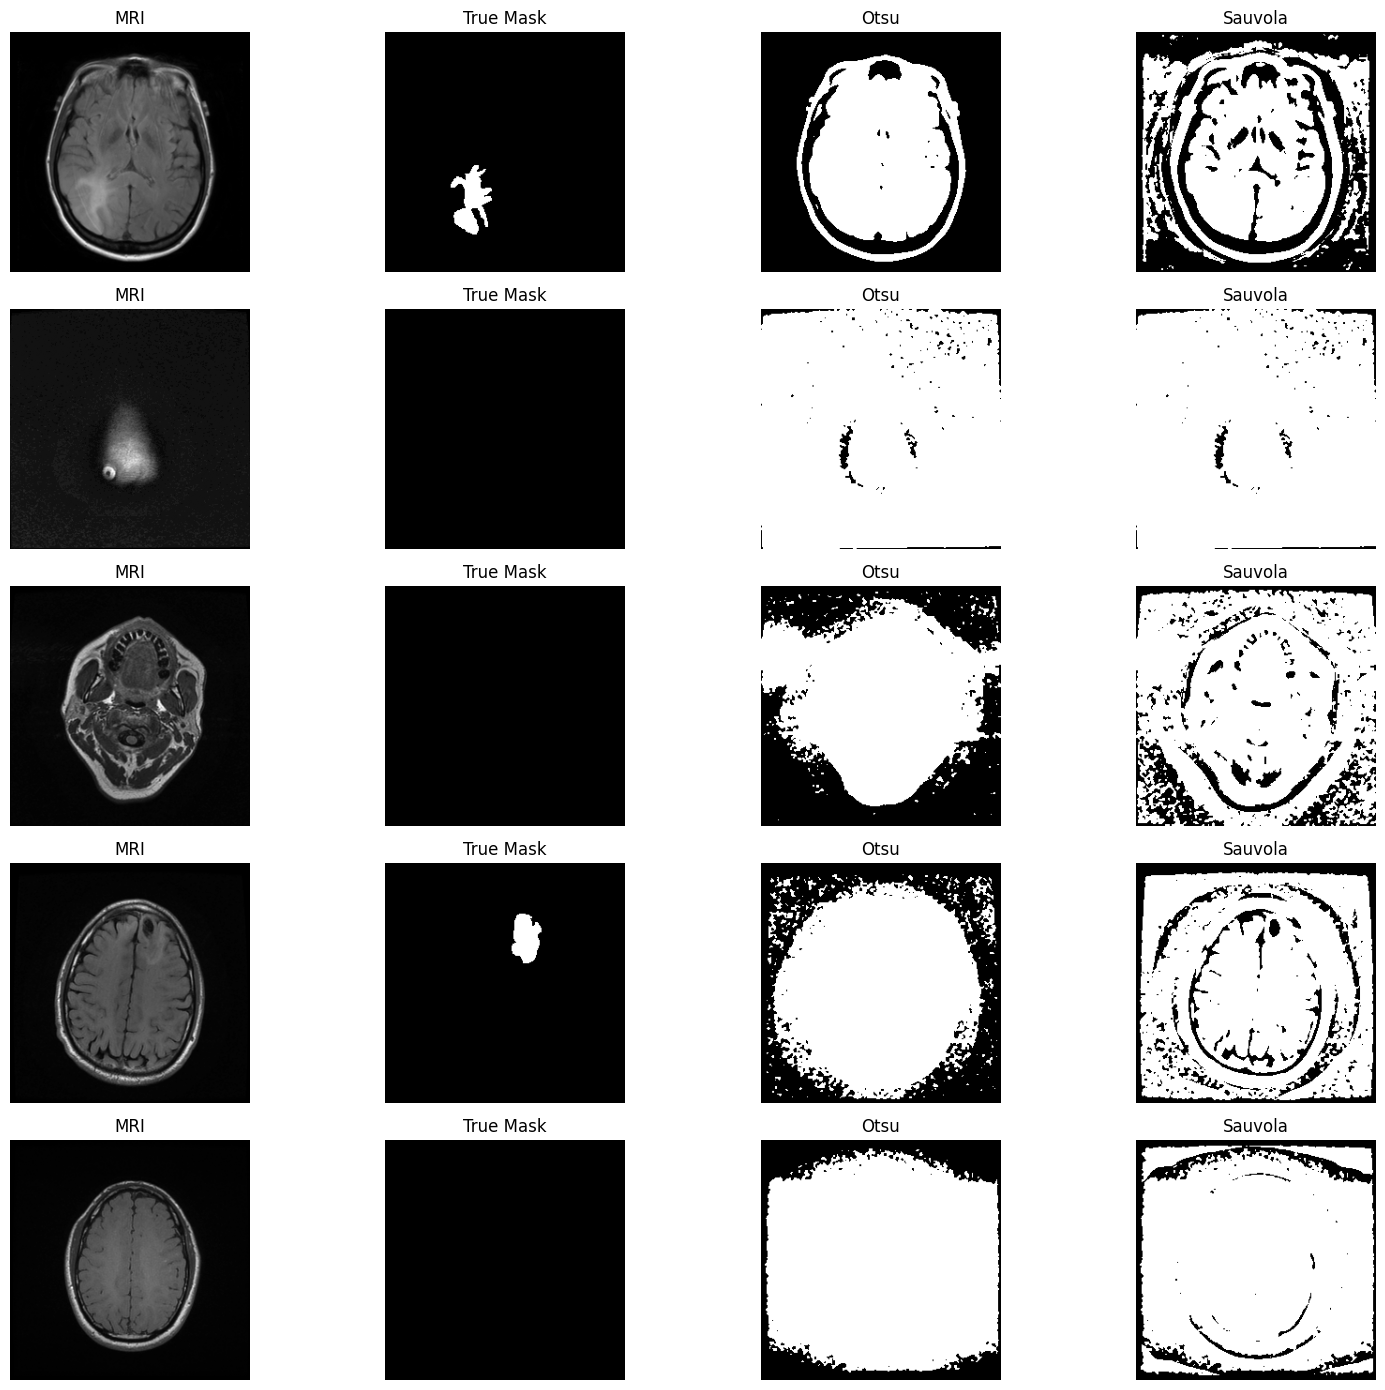

In [39]:
import matplotlib.pyplot as plt
import random
import cv2

idxs = random.sample(range(len(image_paths)), 5)

plt.figure(figsize=(16,14))

for i, idx in enumerate(idxs):

    img  = cv2.imread(image_paths[idx], cv2.IMREAD_GRAYSCALE)
    mask = cv2.imread(mask_paths[idx], cv2.IMREAD_GRAYSCALE)
    mask = (mask > 10).astype(np.uint8)


    otsu = segment_otsu(img)
    sauv = segment_sauvola(img)

    # MRI
    plt.subplot(5,4,4*i+1)
    plt.imshow(img, cmap="gray")
    plt.title("MRI")
    plt.axis("off")

    # True Mask
    plt.subplot(5,4,4*i+2)
    plt.imshow(mask, cmap="gray", vmin=0, vmax=1)
    plt.title("True Mask")
    plt.axis("off")

    # Otsu
    plt.subplot(5,4,4*i+3)
    plt.imshow(otsu, cmap="gray")
    plt.title("Otsu")
    plt.axis("off")

    # Sauvola
    plt.subplot(5,4,4*i+4)
    plt.imshow(sauv, cmap="gray")
    plt.title("Sauvola")
    plt.axis("off")

plt.tight_layout()
plt.show()
